#Identifying Similar Stations

##Introduction

Consider the scenario where the MBTA is looking to conduct a survey of commuter preferences. The MBTA could hire a market research team to survey patrons at each station, but that would not make sense fiscally. Instead, the MBTA could survey riders at a few stations and extend the conclusions to similar stations. One existing way that stations are grouped is by route. MBTA stations along the same route are grouped by line color. This grouping is helpful when looking at a map and planning your trip, but it may not be the most useful way to group stations for analysis. Ridership at the Braintree station may be extremely different than ridership at Park St. 

The motivation of this notebook is to apply Machine Learning techniques to find stations with similar *ridership patterns*, regardless of line color.

In [1]:
# Libraries.
import matplotlib, matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("paper")

# Setup.
% matplotlib inline

# Paths.
path_data = '../../../data/gatecount_%d/'

###Load in Processed Dataset

Running the next cell will load in a processed data set that has the necessary columns for the notebook.

In [2]:
# This dataset is now being using

gatecount_1315=pd.read_csv('../../../data/gatecounts_edit_1315.csv')
gatecount_1315.head()

,Unnamed: 0,locationid,entries,servicedate,servicetime_fraction,weekday,month
0,0,1002,0,2013-01-01 00:00:00,3.00,1,1
1,1,1002,1,2013-01-01 00:00:00,5.00,1,1
2,2,1002,2,2013-01-01 00:00:00,5.25,1,1
3,3,1002,3,2013-01-01 00:00:00,5.50,1,1
4,4,1002,6,2013-01-01 00:00:00,5.75,1,1


##Station Data

Aside from the gate fare data, I also load in some general information about each station. Once the groupings are created, I will append a column containing each station's group so that this information can be used in subsequent analyses.

In [3]:
gate_stations=gatecount_1315.locationid.unique()

# function to preprocess the station id numbers. Only want to keep the stations that appear in gate_count
# For example, silver line stations are included in Stations.csv, but do not appear in gate fare records
def is_in_gate_count(id):
    #print id
    if(len(np.where(gate_stations==id)[0])==0):
        return False
    else :
        return True
    

In [4]:
station_info=pd.read_csv('../../../data/Stations.csv')
# remove rows where line==Nan
station_info=station_info[~station_info['line_temp'].isnull()]
# Take out bus stations
station_info=station_info[station_info['line_temp']!='Bus']
# Take out ids that aren't found in gate_count
station_info=station_info[map(is_in_gate_count,station_info['stationid'].values)]

# Remove some columns
station_info=station_info[['stationid','nameshort','namelong','name','line_temp']]
station_info.head()

,stationid,nameshort,namelong,name,line_temp
20,1002,Andrew Square,1002,Andrew Square,Red
21,1004,JFK/U Mass,1004,JFK/U Mass,Red
22,1005,North Quincy,1005,North Quincy,Red
23,1006,Wollaston,1006,Wollaston,Red
24,1007,Quincy Center,1007,Quincy Center,Red


In [126]:
# save cleaned info for later
station_info.to_csv('../../../data/Stations_clean.csv')

In [5]:
red_stations=station_info[station_info['line_temp']=='Red']
red_stations_ids=list(red_stations.stationid.values)
# Park is only listed on Green in stations.csv. Want to add it to red because its a junction
red_stations_ids.append(1052)
# Downtown Xing is only listed on Orange in stations.csv. Want to add it to red because its a junction
red_stations_ids.append(1039)
print len(red_stations_ids)


blue_stations=station_info[station_info['line_temp']=='Blue']
blue_stations_ids=list(blue_stations.stationid.values)
# Add govt center junction
blue_stations_ids.append(1051)
# add state st
blue_stations_ids.append(1077)
print len(blue_stations_ids)

green_stations=station_info[station_info['line_temp']=='Green']
green_stations_ids=list(green_stations.stationid.values)
#add haymarket
green_stations_ids.append(1076)
#add north station
green_stations_ids.append(1075)
print len(green_stations_ids)

orange_stations=station_info[station_info['line_temp']=='Orange']
orange_stations_ids=list(orange_stations.stationid.values)
print len(orange_stations_ids)



22
12
14
19


In [6]:
from sklearn import preprocessing

##Comparing Stations

The idea of similar stations needs some clarification. Some stations are just as busy in the morning as they are in the evening, while others are busiest during the morning rush hour with no traffic in the evening. One could consider two stations similar if they are busiest at the same time.
For each station, we computed its mean entries at each fifteen minute interval. For simplicity, we only considered weekdays in our dataset as those patterns are much more stable than weekend ridership patterns. One issue that arises when comparing stations is that some have ridership figures that are more than an order magnitude larger than others. We can remove magnitude from each time series so that they have a mean of zero with unit variance. Once scaled, we can look at the time series for two stations in one plot and start to identify similar stations based on their ridership patterns.

Once all series are on an level playing field, the zero-lag correlation of pair-wise comparisons of stations can tell us how similar two stations are. You may be familiar with the use of correlation in the context of two univariate samples, X and Y. [Correlation](http://en.wikipedia.org/wiki/Correlation_and_dependence) is defined by $$\rho_{corr}(X,Y)= \frac{E[(X-\mu_X)(Y-\mu_Y)]}{\sigma_X \sigma_Y} $$ In the case of two univariate samples, correlation coefficients can be interpreted as...
- 1 if the two samples are essentially the same
- -1 if the stations are opposites of one another
- 0 if the stations have no relationship with each other

The two-sample univariate case can be extended to this time series set up where a correlation of 1 denotes that two stations have very similar ridership patterns, and so forth.

Below is a function that computes the pair-wise correlation between a reference station and each station in a list of comparison stations. Note that we are only considering the weekday ridership patterns when computing the correlation

The sample output below shows an example of two time series with of correlation < 0.45 look like when plotted together. This function only considers the morning rush hour but all other analysis in the notebook will consider from 5 a.m. until midnight.


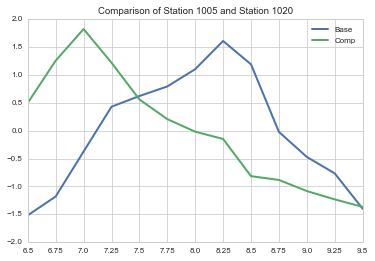

[0.95941052868063048,
 0.95520863602176553,
 1.0000000000000002,
 0.79232042523051205,
 0.89801604990735717,
 0.91362764834815657,
 0.020521725653452536,
 0.99294202938227449,
 0.94392132402928819,
 0.89302297087464289,
 0.81931355372646542,
 0.7699681309376909,
 0.73284698324523212,
 0.9339706392467847,
 0.53867762027415123,
 0.78553851304685129,
 0.69001209039807243,
 0.89855732006890598,
 0.94448955449311367,
 0.76793810240110616,
 0.67387529091767806,
 0.47094688725793543]

In [15]:
## Want to compare portions of time series across various stations. 

def compare_series(station_id,comparison_station=False,begin_time=4.5,end_time=9.5, print_plot=False):
    
    if(not comparison_station):
        comparison_station=[station_id]
    
    station_records=gatecount_1315[gatecount_1315['weekday']<5]
    station_records=station_records[(station_records['servicetime_fraction']<=end_time) & (station_records['servicetime_fraction']>=begin_time) ]
    #get subset of station 
    base_records=station_records[(station_records['locationid']==station_id)]
    base_grouping=base_records[['servicetime_fraction','servicedate','entries']].groupby('servicetime_fraction')
    base_entries=base_grouping.agg(np.mean)['entries']
    
    # Standardize the entries so we can indentify stations with similar behavior without worrying about scale
    base_entries_scaled=preprocessing.scale(base_entries)
    
    correlations=[]
    count=0
    
    for station in comparison_station:
        
        comp_records=station_records[(station_records['locationid']==station)]
        comp_grouping=comp_records[['servicetime_fraction','servicedate','entries']].groupby('servicetime_fraction')
        comp_entries=comp_grouping.agg(np.mean)['entries']
        
        comp_entries_scaled=preprocessing.scale(comp_entries)
        
        # np.correlate for two series of the same length returns a correlation which is <= length of the two series
        # since each pairwise comparison of the terms can yield an individual correlation of 1. Want to think of correlation
        # of series from [-1,1] so I divided by the length of the series
        correlations.append((np.correlate(base_entries_scaled,comp_entries_scaled)*1.0/len(base_entries_scaled))[0])
        
        #plt.figure(figsize=(12,8))

        # Print dissimilar stations
        if(print_plot& (correlations[count]<0.45)):
            plt.plot(base_entries_scaled,label='Base',lw=2)
            plt.plot(comp_entries_scaled,label='Comp',lw=2)
            plt.title('Comparison of Station '+str(station_id)+' and Station '+str(station))
            plt.legend()
            plt.xticks(range(13), list(comp_entries.index))
            plt.show()
        count+=1
        
    return correlations

# sample output
compare_series(1005,comparison_station=red_stations_ids,begin_time=6.5,end_time=9.5,print_plot=True)

##How to Represent Correlation
The function above outputs a vector of correlation values for each pairwise comparison of the reference stations with each of the other stations. Calling this function for each station on the red line as the reference station against all other stations on the red line, we have n vectors, where $n =$ the number of stations on the red line, each of length $n$.  What we need is a good way to represent the pairwise comparisons not just for one station, but for *all* stations. [Similarity matrices](http://en.wikipedia.org/wiki/Similarity_matrix) are an intuitive and condensed way to represent comparisons between many stations

In [ ]:
temp_ids=red_stations_ids

temp_ids.sort()

correlation_vectors=[]

for station in temp_ids:
    print station
    output=compare_series(station,comparison_station=temp_ids,begin_time=5.,end_time=19.5)
    
    correlations_df=pd.DataFrame(zip(temp_ids,output))
    #correlations_df=correlations_df.sort([0])

    correlation_vectors.append(list(correlations_df[1].values))
    

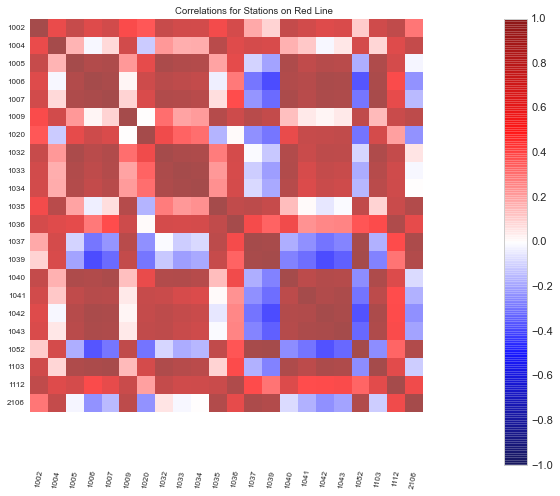

In [18]:

fig, ax = plt.subplots()
heatmap = ax.pcolor(pd.DataFrame(correlation_vectors),cmap=plt.get_cmap('seismic'),alpha=0.7,vmin=-1,vmax=1)
fig = plt.gcf()
fig.set_size_inches(10,8)

ax.invert_yaxis()
ax.grid(False)
ax.set_frame_on(False)

ax.set_yticks(np.arange(len(temp_ids)) + 0.5, minor=False)
ax.set_xticks(np.arange(len(temp_ids))+0.5, minor=False) 

ax.set_xticklabels(temp_ids, minor=False)
ax.set_yticklabels(temp_ids, minor=False)

plt.xticks(rotation=80)
plt.rc('xtick', labelsize=11)
plt.rc('ytick', labelsize=11)
plt.title('Correlations for Stations on Red Line')
colorbar=plt.colorbar(heatmap)

plt.show()



###Comment:

The purpose of the notebook was to identify similar stations. By looking at this similarity matrix, deeper shades of red denote that two stations are very similar while blue denotes dissimilarity. While it's easy to compare any two stations by identifying the correct row and column, it's difficult to name *groups* of similar stations at first sight. It would be nice if the rows and columns were ordered such that similar stations were consecutively ordered on the axes.


##PCA and K-means Clustering

One way to organize the similarity matrix above is to identify similar stations through another method and order the rows according to this other measure of similarity.

As mentioned above, we computed average entries at 15 minute intervals, resulting in 59 measurements for each station. These 59 measurements can be considered a point in $\mathbf{R}^{59}$, the 59-dimensional span of real numbers. People are generally better at picturing things in 2-dimensions than in 59-dimensions. What would really be useful is a way to map our stations down from a 59-dimensional space to a lower-dimensional space while preserving as much of the original information as possible. [Principal Component Analysis](http://en.wikipedia.org/wiki/Principal_component_analysis) is a machine learning technique used to transform data from a high-dimensional space to a lower-dimensional space. The new dimensions are a linear combination of the original dimensions that contain the greatest amount of variation. In simpler terms, PCA is only going to keep the parts of the original dataset that help differentiate the stations from one another. 

From there, we should be able to identify similar stations by how close they are to each other in this lower-dimensional space. [K-means clustering](http://en.wikipedia.org/wiki/K-means_clustering) is a popular machine learning technique used to identify groupings from data points that aren't currently labeled. In our case, the label we seek is a grouping where similar stations belong to the same group. Below is a diagram from Wikipedia explaining the k-means algorithm.

![k_means](https://github.com/azampagl/harvard-capstone/blob/master/src/exploration/k_means.PNG?raw=true)


##Red Line Stations

The analysis will be performed line by line to illustrate clustering within a station, but the final grouping will be derived on the collection of all stations.

In [19]:
from sklearn.decomposition import PCA

In [20]:

# helper function to return station name corresponding to station_id
def get_name(station_id):
    return(station_info[station_info['stationid']==station_id]['name'].values[0])


In [59]:
# Returns a vector of series where each series is the scaled time series for each station in station_ids

# station_ids is a list
def get_scaled_entries(station_ids,begin_time=5,end_time=19.5):

    vector_entries_scaled=[]
    
    for station in station_ids:
        station_records=gatecount_1315[gatecount_1315['weekday']<5]
        station_records=station_records[(station_records['servicetime_fraction']<=end_time) & (station_records['servicetime_fraction']>=begin_time) ]

        #get subset of station 
        base_records=station_records[(station_records['locationid']==station)]
        base_grouping=base_records[['servicetime_fraction','servicedate','entries']].groupby('servicetime_fraction')
        base_entries=base_grouping.agg(np.mean)['entries']

        entries_scaled=preprocessing.scale(base_entries)
        
        vector_entries_scaled.append(list(entries_scaled))
        
    return vector_entries_scaled
    
    ## now for each station, have a vector of scaled entries over the window of interest.
    
c=get_scaled_entries(red_stations_ids)    
        

In [60]:
print "Number of stations: "+str(len(c))
print "Number of time intervals: "+str(len(c[0]))

pca = PCA(n_components=10)
pca.fit(c)

print "Number of PCA components: "+str(len(pca.components_))
print(pca.explained_variance_ratio_) 


Number of stations: 22
Number of time intervals: 59
Number of PCA components: 10
[ 0.77756367  0.12088187  0.04385288  0.01986184  0.00946769  0.00579901
  0.00506189  0.00342932  0.00266491  0.00194105]


###Comments:
It seems that we can capture almost 90% of the variation using only 2 principal components. I will perform PCA with 4 components for now to capture approximately 95% of the variation. 

In [61]:
pca = PCA(n_components=4)
pca.fit(c)

c_transformed=pca.transform(c)

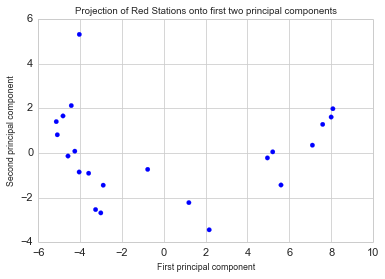

In [62]:
#Visualize the plot of first two principal components
components_transposed=c_transformed.transpose()

plt.scatter(components_transposed[0],components_transposed[1],color='blue',label='Stations')
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.title('Projection of Red Stations onto first two principal components')
plt.show()


###Comments:
Above is the plot of the first two components comprising of the majority of the variation. As promised, it's much easier to visualize the stations in a two-dimensional space than a 59-dimensional space. This is an unsupervised clustering task and I'm not sure how many groups to cluster the stations into. Based on the plot above, it seems like we can use k=3 clusters since you can roughly identify 3 groups of points with the naked eye. I'm not too concerned whether k=2,3, or 4 is the best choice because it's all in an effort to group similar stations closer together on the similarity matrix. Thus, the visual differences between k=2,3,4 won't be too stark.

In [25]:
from sklearn import cluster

[[-4.09453351  0.23384375 -0.19992251 -0.18436462]
 [ 6.64787203  0.51453127  0.08592574 -0.14697023]
 [ 0.86643261 -2.13594796  0.59919662  1.08038903]]


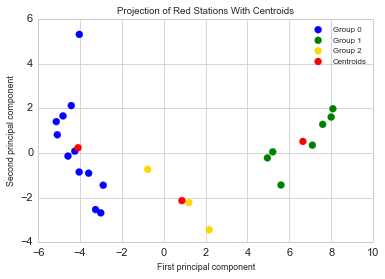

In [66]:
cluster_fn=cluster.KMeans(n_clusters=3)
cluster_fn.fit(c_transformed)

print cluster_fn.cluster_centers_

clusters=cluster_fn.cluster_centers_.transpose()
components_transposed=c_transformed.transpose()

#get the groupings
group0=cluster_fn.labels_==0
group1=cluster_fn.labels_==1
group2=cluster_fn.labels_==2

#plt.figure(figsize=(12,8))
plt.scatter(components_transposed[0][group0],components_transposed[1][group0],s=50,color='blue',label='Group 0')
plt.scatter(components_transposed[0][group1],components_transposed[1][group1],s=50,color='green',label='Group 1')
plt.scatter(components_transposed[0][group2],components_transposed[1][group2],s=50,color='gold',label='Group 2') 
plt.scatter(clusters[0],clusters[1],color='red',label='Centroids',s=50)
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.title('Projection of Red Stations With Centroids')
plt.legend()
plt.show()

###Comments:

In the plot above, the red dots represent the center of the groupings identified by the k-means algorithm. The centroids look pretty reasonable given our data. I'm going to continue with k=3 and see what the similarity matrix ends up looking like.

In [67]:
group_0_ids=np.array(red_stations_ids)[group0]
print "First grouping: "+str(group_0_ids)
group_1_ids=np.array(red_stations_ids)[group1]
print "Second grouping: "+str(group_1_ids)
group_2_ids=np.array(red_stations_ids)[group2]
print "Third grouping: "+str(group_2_ids)

#reorder the IDS so that the similarity matrix has like-grouped ids near each other
reordered_ids=list(group_0_ids)+list(group_2_ids)+list(group_1_ids)
print "Re-ordered ID list: "+str(reordered_ids)


First grouping: [1005 1006 1007 1020 1032 1033 1034 1040 1041 1042 1043 1103]
Second grouping: [1004 1009 1035 1037 1039 1052 2106]
Third grouping: [1002 1036 1112]
Re-ordered ID list: [1005, 1006, 1007, 1020, 1032, 1033, 1034, 1040, 1041, 1042, 1043, 1103, 1002, 1036, 1112, 1004, 1009, 1035, 1037, 1039, 1052, 2106]


##New Similarity Matrix

Now let's build the similarity matrix, this time ordering the axes according to our reordered ID list. Note that the reordered ID list has stations of the same group listed consecutively. This will be the order that the rows are arranged in the similarity matrix.

In [ ]:

temp_ids=reordered_ids

correlation_vectors=[]

for station in temp_ids:
    print station
    output=compare_series(station,comparison_station=temp_ids,begin_time=5.,end_time=19.5)
    
    correlations_df=pd.DataFrame(zip(temp_ids,output))

    correlation_vectors.append(list(correlations_df[1].values))    
    

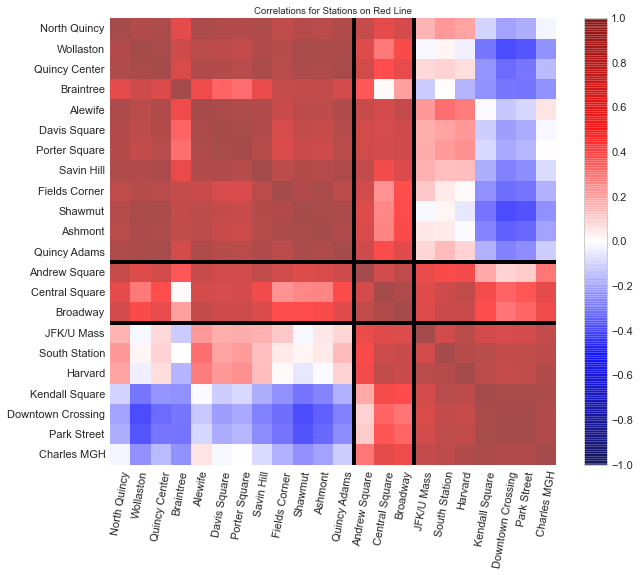

In [69]:
station_names=map(get_name,temp_ids)

fig, ax = plt.subplots()
heatmap = ax.pcolor(pd.DataFrame(correlation_vectors),cmap=plt.get_cmap('seismic'),alpha=0.7,vmin=-1,vmax=1)
fig = plt.gcf()
fig.set_size_inches(10,8)

# Clip the axes to remove white border
plt.ylim(0, len(temp_ids))
plt.xlim(0, len(temp_ids))

#invert so we orient the diagonal properly
ax.invert_yaxis()
ax.grid(False)
ax.set_frame_on(False)

# reorganize the ticks
ax.set_yticks(np.arange(len(temp_ids)) + 0.5, minor=False)
ax.set_xticks(np.arange(len(temp_ids))+0.5, minor=False) 
#put labels on the ticks
ax.set_xticklabels(station_names, minor=False)
ax.set_yticklabels(station_names, minor=False)

plt.xticks(rotation=80)
plt.rc('xtick', labelsize=11)
plt.rc('ytick', labelsize=11)
plt.title('Correlations for Stations on Red Line')
colorbar=plt.colorbar(heatmap)

# plot lines for the groups
plt.axhline(y=len(group_0_ids),xmin=0,xmax=(len(temp_ids)-15),color='black',linewidth=4)
plt.axhline(y=len(group_0_ids)+len(group_2_ids),xmin=0,xmax=(len(temp_ids)-15),color='black',linewidth=4)

plt.axvline(x=len(group_0_ids),ymin=0,ymax=(len(temp_ids)-15),color='black',linewidth=4)
plt.axvline(x=len(group_0_ids)+len(group_2_ids),ymin=0,ymax=(len(temp_ids)-15),color='black',linewidth=4)


plt.show()


###Comments:

This is the organized similarity matrix we desire! Notice the large concentration of red squares along the diagonal and how any dissimilar stations, identified with blue squares, are further away from the diagonal. This is evidence that we were able to identify similar stations with PCA and k-means clustering and organize the rows properly.

The next few sections show the same analysis performed on the other lines followed by the similarity matrix for all stations. Feel free to skip over this portion to the analysis on all stations.

###Green Stations

In [44]:
## green scaled entries    
c=get_scaled_entries(green_stations_ids)    
        
print "Number of stations: "+str(len(c))
print "Number of time intervals: "+str(len(c[0]))

pca = PCA(n_components=10)
pca.fit(c)

print "Number of PCA components: "+str(len(pca.components_))
print(pca.explained_variance_ratio_) 


Number of stations: 14
Number of time intervals: 59
Number of PCA components: 10
[ 0.70666128  0.15291648  0.05047327  0.03086441  0.02673166  0.01110493
  0.00873607  0.00620418  0.00259329  0.00130377]


###Comments: 
3 principal components account for 90% of the variation in the dataset. Like with the red lines, going to use PCA with 4 components just to be safe.

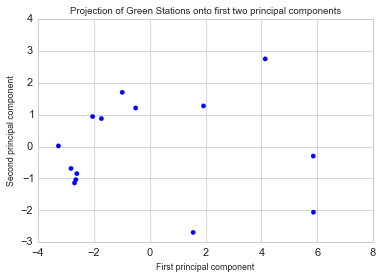

In [45]:

pca = PCA(n_components=4)
pca.fit(c)

c_transformed=pca.transform(c)

#Visualize the plot of first two principal components
components_transposed=c_transformed.transpose()

plt.scatter(components_transposed[0],components_transposed[1],color='blue',label='Stations')
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.title('Projection of Green Stations onto first two principal components')
plt.show()

###Comments:

Seems like 3 clusters may be sufficient again.

[[ 5.86167307 -1.17921854  0.93484901  0.15354039]
 [-2.14871859  0.11435034  0.15370392 -0.00732814]
 [ 2.53837372  0.44309467 -1.08434443 -0.08037585]]


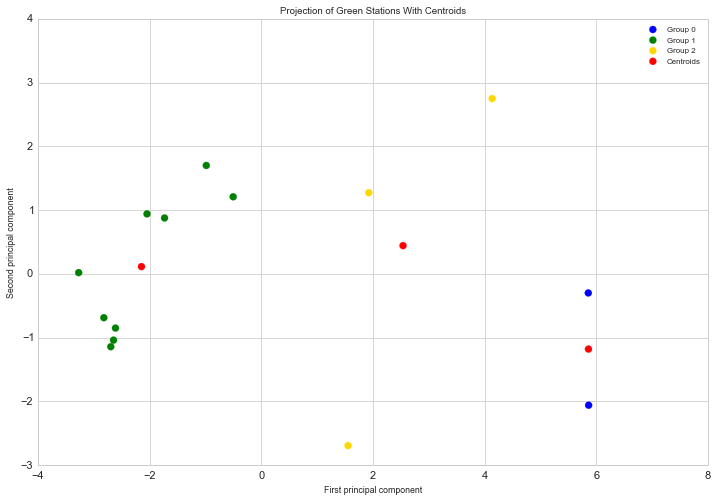

In [46]:
cluster_fn=cluster.KMeans(n_clusters=3)
cluster_fn.fit(c_transformed)

print cluster_fn.cluster_centers_

clusters=cluster_fn.cluster_centers_.transpose()
components_transposed=c_transformed.transpose()

#get the groupings
group0=cluster_fn.labels_==0
group1=cluster_fn.labels_==1
group2=cluster_fn.labels_==2
#group3=cluster_fn.labels_==3

plt.figure(figsize=(12,8))
plt.scatter(components_transposed[0][group0],components_transposed[1][group0],s=50,color='blue',label='Group 0')
plt.scatter(components_transposed[0][group1],components_transposed[1][group1],s=50,color='green',label='Group 1')
plt.scatter(components_transposed[0][group2],components_transposed[1][group2],s=50,color='gold',label='Group 2') 
#plt.scatter(components_transposed[0][group3],components_transposed[1][group3],s=50,color='brown',label='Group 3') 
plt.scatter(clusters[0],clusters[1],color='red',label='Centroids',s=50)
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.title('Projection of Green Stations With Centroids')
plt.legend()
plt.show()

In [47]:
group_0_ids=np.array(green_stations_ids)[group0]
print "First grouping: "+str(group_0_ids)
group_1_ids=np.array(green_stations_ids)[group1]
print "Second grouping: "+str(group_1_ids)
group_2_ids=np.array(green_stations_ids)[group2]
print "Third grouping: "+str(group_2_ids)

#reorder the IDS so that the similarity matrix has like-grouped ids near each other
reordered_ids=list(group_1_ids)+list(group_2_ids)+list(group_0_ids)
print "Re-ordered ID list: "+str(reordered_ids)

First grouping: [1101 1075]
Second grouping: [1051 1052 1053 1054 1055 1057 1058 1059 1060]
Third grouping: [1056 1061 1076]
Re-ordered ID list: [1051, 1052, 1053, 1054, 1055, 1057, 1058, 1059, 1060, 1056, 1061, 1076, 1101, 1075]


In [ ]:

temp_ids=reordered_ids

correlation_vectors=[]

for station in temp_ids:
    print station
    output=compare_series(station,comparison_station=temp_ids,begin_time=5.,end_time=19.5)
    
    correlations_df=pd.DataFrame(zip(temp_ids,output))

    correlation_vectors.append(list(correlations_df[1].values))    
    

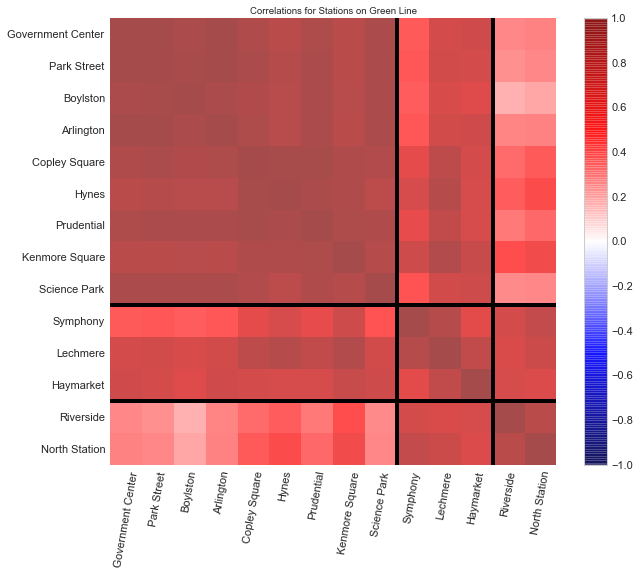

In [49]:
station_names=map(get_name,temp_ids)

fig, ax = plt.subplots()
heatmap = ax.pcolor(pd.DataFrame(correlation_vectors),cmap=plt.get_cmap('seismic'),alpha=0.7,vmin=-1,vmax=1)
fig = plt.gcf()
fig.set_size_inches(10,8)

# Clip the axes to remove white border
plt.ylim(0, len(temp_ids))
plt.xlim(0, len(temp_ids))

#invert so we orient the diagonal properly
ax.invert_yaxis()
ax.grid(False)
ax.set_frame_on(False)

# reorganize the ticks
ax.set_yticks(np.arange(len(temp_ids)) + 0.5, minor=False)
ax.set_xticks(np.arange(len(temp_ids))+0.5, minor=False) 
#put labels on the ticks
ax.set_xticklabels(station_names, minor=False)
ax.set_yticklabels(station_names, minor=False)

plt.xticks(rotation=80)
plt.rc('xtick', labelsize=11)
plt.rc('ytick', labelsize=11)
plt.title('Correlations for Stations on Green Line')
colorbar=plt.colorbar(heatmap)

# plot lines for the groups
plt.axhline(y=len(group_1_ids),xmin=0,xmax=(len(temp_ids)),color='black',linewidth=4)
plt.axhline(y=len(group_1_ids)+len(group_2_ids),xmin=0,xmax=(len(temp_ids)),color='black',linewidth=4)

plt.axvline(x=len(group_1_ids),ymin=0,ymax=(len(temp_ids)),color='black',linewidth=4)
plt.axvline(x=len(group_1_ids)+len(group_2_ids),ymin=0,ymax=(len(temp_ids)),color='black',linewidth=4)


plt.show()


###Comments:
It's interesting to note that the stations on the green line are all pretty similar to one another. While some are 'more similar' than others, the similarity matrix shows positive correlations for all green line station comparisons.


##Blue Lines

In [50]:
## green scaled entries    
c=get_scaled_entries(blue_stations_ids)    
        
print "Number of stations: "+str(len(c))
print "Number of time intervals: "+str(len(c[0]))

pca = PCA(n_components=10)
pca.fit(c)

print "Number of PCA components: "+str(len(pca.components_))
print(pca.explained_variance_ratio_) 


Number of stations: 12
Number of time intervals: 59
Number of PCA components: 10
[ 0.90825734  0.03835394  0.01730337  0.00929305  0.00771629  0.00595549
  0.00415006  0.00357851  0.00301575  0.00195743]


###Comments:
90% of the variation is captured with one principal component! I'll reduce my parameter space to two dimensions.

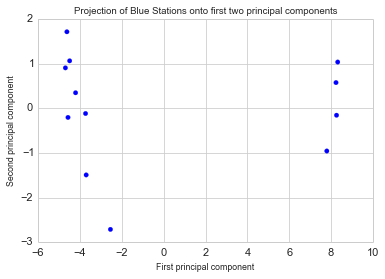

In [51]:

pca = PCA(n_components=2)
pca.fit(c)

c_transformed=pca.transform(c)

#Visualize the plot of first two principal components
components_transposed=c_transformed.transpose()

plt.scatter(components_transposed[0],components_transposed[1],color='blue',label='Stations')
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.title('Projection of Blue Stations onto first two principal components')
plt.show()

###Comments:
Two clusters is definitely enough.

[[-4.07482045 -0.06235657]
 [ 8.1496409   0.12471314]]


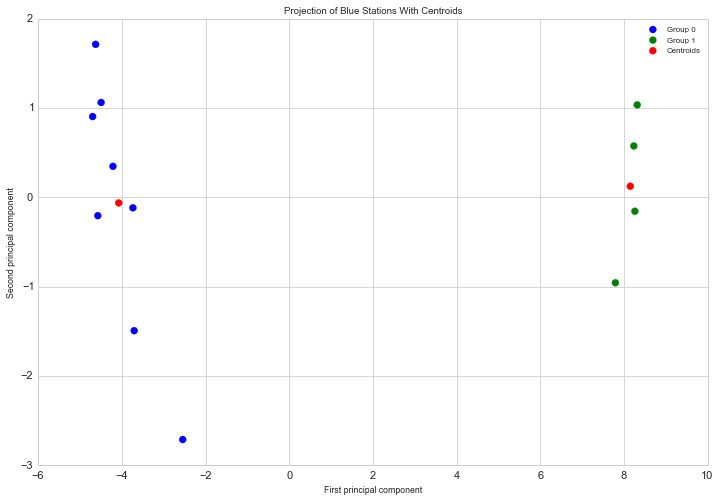

In [52]:
cluster_fn=cluster.KMeans(n_clusters=2)
cluster_fn.fit(c_transformed)

print cluster_fn.cluster_centers_

clusters=cluster_fn.cluster_centers_.transpose()
components_transposed=c_transformed.transpose()

#get the groupings
group0=cluster_fn.labels_==0
group1=cluster_fn.labels_==1

plt.figure(figsize=(12,8))
plt.scatter(components_transposed[0][group0],components_transposed[1][group0],s=50,color='blue',label='Group 0')
plt.scatter(components_transposed[0][group1],components_transposed[1][group1],s=50,color='green',label='Group 1')
plt.scatter(clusters[0],clusters[1],color='red',label='Centroids',s=50)
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.title('Projection of Blue Stations With Centroids')
plt.legend()
plt.show()

In [53]:
group_0_ids=np.array(blue_stations_ids)[group0]
print "First grouping: "+str(group_0_ids)
group_1_ids=np.array(blue_stations_ids)[group1]
print "Second grouping: "+str(group_1_ids)


#reorder the IDS so that the similarity matrix has like-grouped ids near each other
reordered_ids=list(group_1_ids)+list(group_0_ids)
print "Re-ordered ID list: "+str(reordered_ids)
temp_ids=reordered_ids

correlation_vectors=[]

for station in temp_ids:
    print station
    output=compare_series(station,comparison_station=temp_ids,begin_time=5.,end_time=19.5)
    
    correlations_df=pd.DataFrame(zip(temp_ids,output))

    correlation_vectors.append(list(correlations_df[1].values))    
    

First grouping: [1010 1011 1013 1014 1015 1016 1017 1018]
Second grouping: [1012 1019 1051 1077]
Re-ordered ID list: [1012, 1019, 1051, 1077, 1010, 1011, 1013, 1014, 1015, 1016, 1017, 1018]
1012
1019
1051
1077
1010
1011
1013
1014
1015
1016
1017
1018


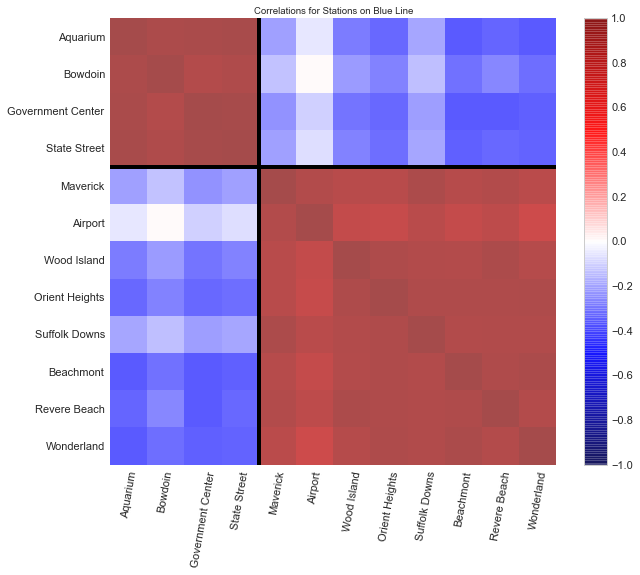

In [54]:
station_names=map(get_name,temp_ids)

fig, ax = plt.subplots()
heatmap = ax.pcolor(pd.DataFrame(correlation_vectors),cmap=plt.get_cmap('seismic'),alpha=0.7,vmin=-1,vmax=1)
fig = plt.gcf()
fig.set_size_inches(10,8)

# Clip the axes to remove white border
plt.ylim(0, len(temp_ids))
plt.xlim(0, len(temp_ids))

#invert so we orient the diagonal properly
ax.invert_yaxis()
ax.grid(False)
ax.set_frame_on(False)

# reorganize the ticks
ax.set_yticks(np.arange(len(temp_ids)) + 0.5, minor=False)
ax.set_xticks(np.arange(len(temp_ids))+0.5, minor=False) 
#put labels on the ticks
ax.set_xticklabels(station_names, minor=False)
ax.set_yticklabels(station_names, minor=False)

plt.xticks(rotation=80)
plt.rc('xtick', labelsize=11)
plt.rc('ytick', labelsize=11)
plt.title('Correlations for Stations on Blue Line')
colorbar=plt.colorbar(heatmap)

# plot lines for the groups
plt.axhline(y=len(group_1_ids),xmin=0,xmax=(len(temp_ids)),color='black',linewidth=4)

plt.axvline(x=len(group_1_ids),ymin=0,ymax=(len(temp_ids)),color='black',linewidth=4)


plt.show()


###Quick comment:

The blue line stations are much more separable than the other lines. Note that the two groupings seem to follow those stations in Boston versus East Boston.

##Orange Stations

In [70]:
## green scaled entries    
c=get_scaled_entries(orange_stations_ids)    
        
print "Number of stations: "+str(len(c))
print "Number of time intervals: "+str(len(c[0]))

pca = PCA(n_components=10)
pca.fit(c)

print "Number of PCA components: "+str(len(pca.components_))
print(pca.explained_variance_ratio_) 


Number of stations: 19
Number of time intervals: 59
Number of PCA components: 10
[ 0.78397383  0.06836642  0.05341448  0.03464654  0.01826433  0.01317482
  0.00887342  0.00673241  0.00315521  0.00264334]


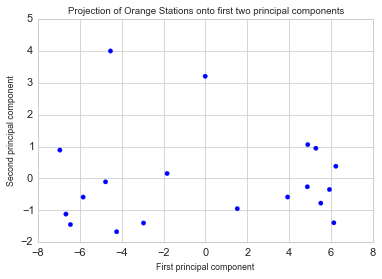

In [71]:

pca = PCA(n_components=4)
pca.fit(c)

c_transformed=pca.transform(c)

#Visualize the plot of first two principal components
components_transposed=c_transformed.transpose()

plt.scatter(components_transposed[0],components_transposed[1],color='blue',label='Stations')
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.title('Projection of Orange Stations onto first two principal components')
plt.show()

###Comments:
Consider using k=3 clusters

[[-5.64043167 -0.00608484 -0.58744744 -0.13036626]
 [ 5.34574341 -0.12105565 -0.39327983  0.01162935]
 [-0.8207314   0.25275978  1.81459269  0.20488226]]


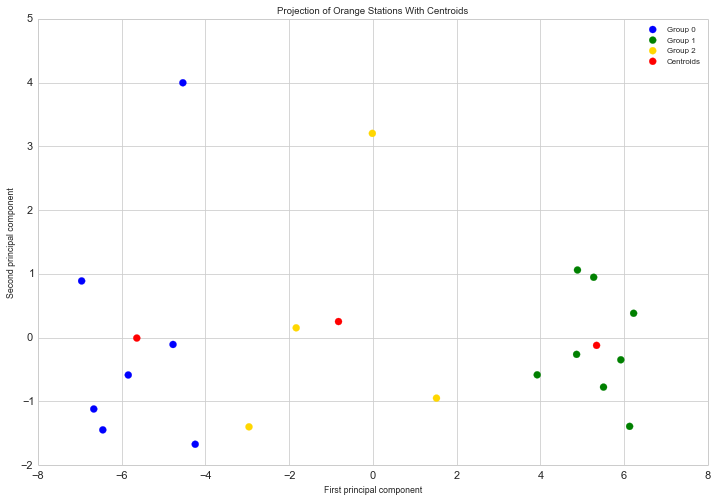

In [73]:
cluster_fn=cluster.KMeans(n_clusters=3)
cluster_fn.fit(c_transformed)

print cluster_fn.cluster_centers_

clusters=cluster_fn.cluster_centers_.transpose()
components_transposed=c_transformed.transpose()

#get the groupings
group0=cluster_fn.labels_==0
group1=cluster_fn.labels_==1
group2=cluster_fn.labels_==2


plt.figure(figsize=(12,8))
plt.scatter(components_transposed[0][group0],components_transposed[1][group0],s=50,color='blue',label='Group 0')
plt.scatter(components_transposed[0][group1],components_transposed[1][group1],s=50,color='green',label='Group 1')
plt.scatter(components_transposed[0][group2],components_transposed[1][group2],s=50,color='gold',label='Group 2')
plt.scatter(clusters[0],clusters[1],color='red',label='Centroids',s=50)
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.title('Projection of Orange Stations With Centroids')
plt.legend()
plt.show()

In [74]:
group_0_ids=np.array(orange_stations_ids)[group0]
print "First grouping: "+str(group_0_ids)
group_1_ids=np.array(orange_stations_ids)[group1]
print "Second grouping: "+str(group_1_ids)
group_2_ids=np.array(orange_stations_ids)[group2]
print "Third grouping: "+str(group_2_ids)


#reorder the IDS so that the similarity matrix has like-grouped ids near each other
reordered_ids=list(group_0_ids)+list(group_2_ids)+list(group_1_ids)
print "Re-ordered ID list: "+str(reordered_ids)
temp_ids=reordered_ids

correlation_vectors=[]

for station in temp_ids:
    print station
    output=compare_series(station,comparison_station=temp_ids,begin_time=5.,end_time=19.5)
    
    correlations_df=pd.DataFrame(zip(temp_ids,output))

    correlation_vectors.append(list(correlations_df[1].values))    
    

First grouping: [1039 1074 1077 1078 1079 1080 1082]
Second grouping: [1070 1071 1072 1073 1084 1085 1086 1087]
Third grouping: [1075 1076 1081 1083]
Re-ordered ID list: [1039, 1074, 1077, 1078, 1079, 1080, 1082, 1075, 1076, 1081, 1083, 1070, 1071, 1072, 1073, 1084, 1085, 1086, 1087]
1039
1074
1077
1078
1079
1080
1082
1075
1076
1081
1083
1070
1071
1072
1073
1084
1085
1086
1087


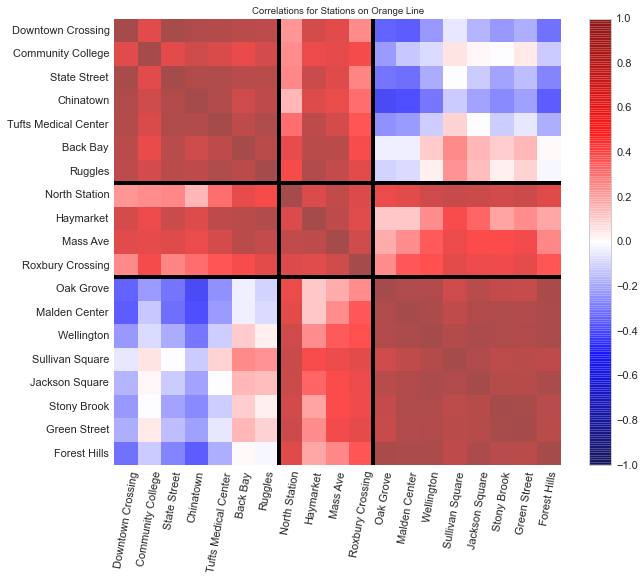

In [75]:
station_names=map(get_name,temp_ids)

fig, ax = plt.subplots()
heatmap = ax.pcolor(pd.DataFrame(correlation_vectors),cmap=plt.get_cmap('seismic'),alpha=0.7,vmin=-1,vmax=1)
fig = plt.gcf()
fig.set_size_inches(10,8)

# Clip the axes to remove white border
plt.ylim(0, len(temp_ids))
plt.xlim(0, len(temp_ids))

#invert so we orient the diagonal properly
ax.invert_yaxis()
ax.grid(False)
ax.set_frame_on(False)

# reorganize the ticks
ax.set_yticks(np.arange(len(temp_ids)) + 0.5, minor=False)
ax.set_xticks(np.arange(len(temp_ids))+0.5, minor=False) 
#put labels on the ticks
ax.set_xticklabels(station_names, minor=False)
ax.set_yticklabels(station_names, minor=False)

plt.xticks(rotation=80)
plt.rc('xtick', labelsize=11)
plt.rc('ytick', labelsize=11)
plt.title('Correlations for Stations on Orange Line')
colorbar=plt.colorbar(heatmap)

# plot lines for the groups
plt.axhline(y=len(group_0_ids),xmin=0,xmax=(len(temp_ids)),color='black',linewidth=4)
plt.axhline(y=len(group_0_ids)+len(group_2_ids),xmin=0,xmax=(len(temp_ids)),color='black',linewidth=4)

plt.axvline(x=len(group_0_ids),ymin=0,ymax=(len(temp_ids)),color='black',linewidth=4)
plt.axvline(x=len(group_0_ids)+len(group_2_ids),ymin=0,ymax=(len(temp_ids)),color='black',linewidth=4)


plt.show()


#All Stations

Try to run similarity matrix across all stations, see if we can cluster.

In [76]:
all_ids=orange_stations_ids+blue_stations_ids+red_stations_ids+green_stations_ids

In [77]:

c=get_scaled_entries(all_ids)    
        
print "Number of stations: "+str(len(c))
print "Number of time intervals: "+str(len(c[0]))

pca = PCA(n_components=10)
pca.fit(c)

print "Number of PCA components: "+str(len(pca.components_))
print(pca.explained_variance_ratio_) 


Number of stations: 67
Number of time intervals: 59
Number of PCA components: 10
[ 0.79430153  0.07933529  0.03933715  0.02921026  0.01094845  0.00869538
  0.00625548  0.00486287  0.00464133  0.00350084]


###Comments:
90% of variation is captured in only two principal components. I'm going to keep 4 components.

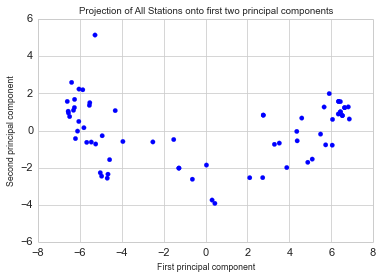

In [78]:

pca = PCA(n_components=4)
pca.fit(c)

c_transformed=pca.transform(c)

#Visualize the plot of first two principal components
components_transposed=c_transformed.transpose()

plt.scatter(components_transposed[0],components_transposed[1],color='blue',label='Stations')
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.title('Projection of All Stations onto first two principal components')
plt.show()

[[ 5.49045892  0.40392596  0.02161905 -0.05701207]
 [-5.62888594  0.37809589  0.15954156 -0.2028939 ]
 [-0.16145022 -2.23005376 -0.50941159  0.73343793]]


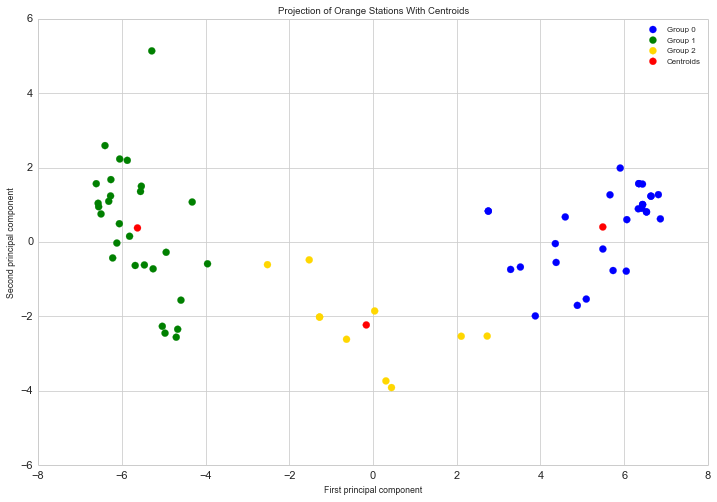

In [79]:
cluster_fn=cluster.KMeans(n_clusters=3)
cluster_fn.fit(c_transformed)

print cluster_fn.cluster_centers_

clusters=cluster_fn.cluster_centers_.transpose()
components_transposed=c_transformed.transpose()

#get the groupings
group0=cluster_fn.labels_==0
group1=cluster_fn.labels_==1
group2=cluster_fn.labels_==2
#group3=cluster_fn.labels_==3


plt.figure(figsize=(12,8))
plt.scatter(components_transposed[0][group0],components_transposed[1][group0],s=50,color='blue',label='Group 0')
plt.scatter(components_transposed[0][group1],components_transposed[1][group1],s=50,color='green',label='Group 1')
plt.scatter(components_transposed[0][group2],components_transposed[1][group2],s=50,color='gold',label='Group 2')
#plt.scatter(components_transposed[0][group3],components_transposed[1][group3],s=50,color='purple',label='Group 3')
plt.scatter(clusters[0],clusters[1],color='red',label='Centroids',s=50)
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.title('Projection of Orange Stations With Centroids')
plt.legend()
plt.show()

In [80]:
group_0_ids=np.array(all_ids)[group0]
print "First grouping: "+str(group_0_ids)
group_1_ids=np.array(all_ids)[group1]
print "Second grouping: "+str(group_1_ids)
group_2_ids=np.array(all_ids)[group2]
print "Third grouping: "+str(group_2_ids)



#reorder the IDS so that the similarity matrix has like-grouped ids near each other
reordered_ids=list(group_1_ids)+list(group_2_ids)+list(group_0_ids)
print "Re-ordered ID list: "+str(reordered_ids)
temp_ids=reordered_ids

correlation_vectors=[]
count=0
for station in temp_ids:
    if(count%5==0):
        print station
        
    count+=1
    output=compare_series(station,comparison_station=temp_ids,begin_time=5.,end_time=19.5)
    
    correlations_df=pd.DataFrame(zip(temp_ids,output))

    correlation_vectors.append(list(correlations_df[1].values))    
    

First grouping: [1039 1074 1076 1077 1078 1079 1080 1082 1012 1019 1051 1077 1004 1009 1035
 1037 1039 1052 2106 1051 1052 1053 1054 1055 1057 1058 1059 1060 1076]
Second grouping: [1070 1071 1072 1073 1084 1085 1086 1087 1010 1011 1013 1014 1015 1016 1017
 1018 1005 1006 1007 1020 1032 1033 1034 1040 1041 1042 1043 1103]
Third grouping: [1075 1081 1083 1002 1036 1112 1056 1061 1101 1075]
Re-ordered ID list: [1070, 1071, 1072, 1073, 1084, 1085, 1086, 1087, 1010, 1011, 1013, 1014, 1015, 1016, 1017, 1018, 1005, 1006, 1007, 1020, 1032, 1033, 1034, 1040, 1041, 1042, 1043, 1103, 1075, 1081, 1083, 1002, 1036, 1112, 1056, 1061, 1101, 1075, 1039, 1074, 1076, 1077, 1078, 1079, 1080, 1082, 1012, 1019, 1051, 1077, 1004, 1009, 1035, 1037, 1039, 1052, 2106, 1051, 1052, 1053, 1054, 1055, 1057, 1058, 1059, 1060, 1076]
1070
1085
1013
1018
1032
1042
1083
1061
1076
1082
1004
1052
1054
1060


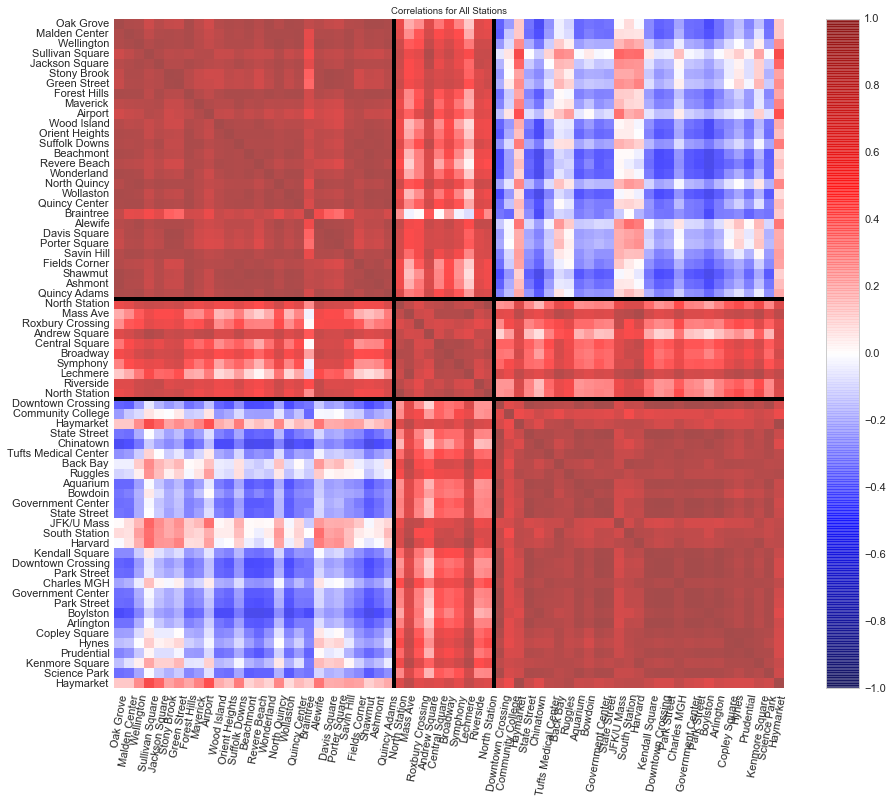

In [81]:
station_names=map(get_name,temp_ids)

fig, ax = plt.subplots()
heatmap = ax.pcolor(pd.DataFrame(correlation_vectors),cmap=plt.get_cmap('seismic'),alpha=0.7,vmin=-1,vmax=1)
fig = plt.gcf()
fig.set_size_inches(15,12)

# Clip the axes to remove white border
plt.ylim(0, len(temp_ids))
plt.xlim(0, len(temp_ids))

#invert so we orient the diagonal properly
ax.invert_yaxis()
ax.grid(False)
ax.set_frame_on(False)

# reorganize the ticks
ax.set_yticks(np.arange(len(temp_ids)) + 0.5, minor=False)
ax.set_xticks(np.arange(len(temp_ids))+0.5, minor=False) 
#put labels on the ticks
ax.set_xticklabels(station_names, minor=False)
ax.set_yticklabels(station_names, minor=False)

plt.xticks(rotation=80)
plt.rc('xtick', labelsize=11)
plt.rc('ytick', labelsize=11)
plt.title('Correlations for All Stations')
colorbar=plt.colorbar(heatmap)

# plot lines for the groups
plt.axhline(y=len(group_1_ids),xmin=0,xmax=(len(temp_ids)),color='black',linewidth=4)
plt.axhline(y=len(group_1_ids)+len(group_2_ids),xmin=0,xmax=(len(temp_ids)),color='black',linewidth=4)

plt.axvline(x=len(group_1_ids),ymin=0,ymax=(len(temp_ids)),color='black',linewidth=4)
plt.axvline(x=len(group_1_ids)+len(group_2_ids),ymin=0,ymax=(len(temp_ids)),color='black',linewidth=4)

plt.savefig('all_stations.png',format='png')
plt.show()


###Comments:

Victory! Remember that we set out to find ways to identify similar stations that was based upon ridership patterns rather than the line to which a station belongs. 

It's good to see that the analysis we ran on each line scaled well when considered comparisons between all stations. 

##Note:
When looking at box plots below, the top group of stations in the similarity matrix is group1, the middle is group 2, and the bottom is group 0.

###Save groupings for later

In [82]:
##Save Groupings!
global_group_0=group_0_ids
global_group_1=group_1_ids
global_group_2=group_2_ids

In [ ]:
# Store the groupings into t he stations data frame

grouping_dict={}

for station in global_group_0:
    grouping_dict[station]=0
    
for station in global_group_1:
    grouping_dict[station]=1
    
for station in global_group_2:
    grouping_dict[station]=2
   
#want to map station id to column for grouping
def group_col(station_id):
    return grouping_dict[station_id]

station_info['grouping']=map(group_col,station_info['stationid'].values)


# Comments on the Groupings

When I first looked at the names of stations within Group 1, such as Oak Grove, Sullivan Square, and Savin Hill, I noticed that I hardly ever used those stations as they are on the far reaches of the orange, blue and red lines. However, I'm very familiar with a lot of the stations in Group 0, like Government Center, Downtown Crossing, and Park Street, because I often use them to go downtown. Using Boston City Hall as an unofficial city center, we can visualize the box plots of distances from City Hall within each of our three groups.

In [85]:
##read in a stations csv with lat/long values
stations_latlong=pd.read_csv('../../../data/stations_with_dist.csv')
stations_latlong.head()

,Unnamed: 0,locationid,name,lat,lon,dist_to_center
0,0,1002,Andrew Square,42.329550,-71.056960,3.404767
1,1,1004,JFK/U Mass,42.321438,-71.052393,4.328881
2,2,1005,North Quincy,42.274816,-71.029176,9.777437
3,3,1006,Wollaston,42.265615,-71.019402,10.976943
4,4,1007,Quincy Center,42.250879,-71.004798,12.909591


In [132]:
latlong=stations_latlong[['locationid','dist_to_center']]

In [140]:
station_info=station_info.merge(latlong,left_on='stationid',right_on='locationid')

#station_info=station_info[['stationid','nameshort','namelong','name','line_temp','grouping','dist_to_center']]
station_info.head()

,Unnamed: 0,stationid,nameshort,namelong,name,line_temp,grouping,locationid,dist_to_center
0,20,1002,Andrew Square,1002,Andrew Square,Red,2,1002,3.404767
1,21,1004,JFK/U Mass,1004,JFK/U Mass,Red,0,1004,4.328881
2,22,1005,North Quincy,1005,North Quincy,Red,1,1005,9.777437
3,23,1006,Wollaston,1006,Wollaston,Red,1,1006,10.976943
4,24,1007,Quincy Center,1007,Quincy Center,Red,1,1007,12.909591


In [151]:
# more saving, just to be safe
station_info=station_info[['stationid','name','line_temp','grouping','dist_to_center']]
station_info.head()

station_info.to_csv('../../../data/Stations_clean.csv')

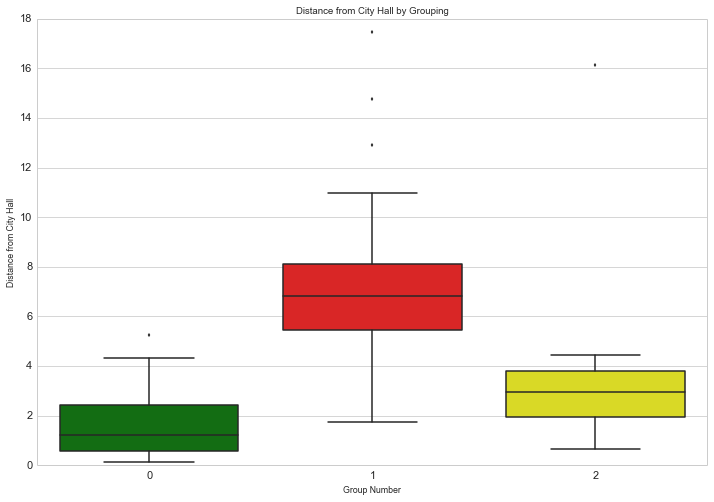

In [90]:
plt.figure(figsize=(12,8))

sns.boxplot(station_info['dist_to_center'],groupby=station_info['grouping'],color=['green','red','yellow'])
plt.xlabel('Group Number')
plt.ylabel('Distance from City Hall')
plt.title('Distance from City Hall by Grouping')
plt.show()

In [148]:
print "Group 0 stations: "+ ', '.join(map(get_name,group_0_ids))
print
print "Group 1 stations: "+ ', '.join(map(get_name,group_1_ids))
print
print "Group 2 stations: "+ ', '.join(map(get_name,group_2_ids))

Group 0 stations: Downtown Crossing, Community College, Haymarket, State Street, Chinatown, Tufts Medical Center, Back Bay, Ruggles, Aquarium, Bowdoin, Government Center, State Street, JFK/U Mass, South Station, Harvard, Kendall Square, Downtown Crossing, Park Street, Charles MGH, Government Center, Park Street, Boylston, Arlington, Copley Square, Hynes, Prudential, Kenmore Square, Science Park, Haymarket

Group 1 stations: Oak Grove, Malden Center , Wellington , Sullivan Square, Jackson Square, Stony Brook, Green Street, Forest Hills, Maverick, Airport, Wood Island, Orient Heights, Suffolk Downs, Beachmont, Revere Beach, Wonderland, North Quincy, Wollaston, Quincy Center, Braintree, Alewife, Davis Square, Porter Square, Savin Hill, Fields Corner, Shawmut, Ashmont, Quincy Adams

Group 2 stations: North Station, Mass Ave, Roxbury Crossing, Andrew Square, Central Square, Broadway, Symphony, Lechmere, Riverside, North Station


###Comments on Groupings:
The box plots above affirm what I saw just by looking at station names within our grouping, namely that stations within groupings not only share similar ridership patterns, but also they are similarly distanced from Boston City Hall. Group 0 stations, including most notably Government Center, Copley, Kenmore, and South Station, are much closer to downtown than the other two groupings. Group 1 stations are much further from downtown, as in the case of Alewife, Braintree, and Forest Hills. Group 2 comprises of those stations that may not be outside of the city limits, but are not as close to downtown as Group 0 stations.


Below you can see our groupings overlayed onto the standard MBTA map. Note how the Group 0 stations are all centered around Government Center and how Group 1 stations are all towards the outskirts of the city and extend into the neighborhing suburbs. The really interesting cases are the intermediary Group 2 stations. Note that there are Group 0 stations that are geographically further from the city center than Group 2 stations (ie Central/Harvard and JFK/Broadway). Our methods were able to detect significant differences in ridership patterns at those stations that does not follow a simple geographic relation. 

Our contact at the MBTA explained that stations at Central, Broadway, and Andrew are considered *peak load points*. In the morning, inbound trains leaving Alewife, Braintree, and Ashmont all pick up large amounts of commuters entering the city. It's only upon reaching Central, Broadway, and Andrew that a lot of people start to exit the trains. In the afternoon, the reverse phenomenon occurs where outbound red line trains accumulate a lot of passengers from South Station to Kendall, and then the passengers disembark en masse at Central/JFK/ Broadway and beyond. 

Other fine details include...
- North Station belonging to Group 2. Its ridership patterns are largely affected by the Commuter Rail and Amtrak trains flowing into the station.
- Harvard belonging to Group 0. This station has an interesting history as it was once the terminal station on the red line so many bus routes run through Harvard Square. It is still a morning destination for many commuters as students and professionals disembark here in the morning.
- JFK/UMass is classified as a Group 0 station while it is further away from City Hall than Broadway and Andrew. JFK/UMass is less residential than neighboring stations and the nearby destinations like UMass Boston may serve as a terminal morning destination for many commuters. This likens its ridership more to downtown Group 0 stations than the Group 1 stations further from the city.

![map](Similar Stations/mbta_edit.png)


##Plotting Dist from center vs. AM/PM Ratio 

Here's an example of the clarity our grouping can provide. One statistic of interest when looking at stations is their ratio of morning rush hour entries compared to evening rush hour entries. When plotting a station's distance from downtown against this ratio and coloring the plot by line color, there is no clear pattern under this grouping

In [171]:

subset=gatecount_1315[gatecount_1315['weekday']<5]

am_rush_bool=((subset['servicetime_fraction']>=6.5) & (subset['servicetime_fraction']<=9.5))
pm_rush_bool=((subset['servicetime_fraction']>=16.5) & (subset['servicetime_fraction']<=19.5))

subset['am_rush']=am_rush_bool
subset['pm_rush']=pm_rush_bool

subset['rush_hour']= (am_rush_bool | pm_rush_bool)

subset=subset[subset['rush_hour']==True]
subset.head()


,Unnamed: 0,locationid,entries,exits,servicedate,servicetime_fraction,weekday,am_rush,pm_rush,rush_hour
7,7,1002,19,4,2013-01-01 00:00:00,6.50,1,True,False,True
8,8,1002,9,5,2013-01-01 00:00:00,6.75,1,True,False,True
9,9,1002,14,3,2013-01-01 00:00:00,7.00,1,True,False,True
10,10,1002,23,6,2013-01-01 00:00:00,7.25,1,True,False,True
11,11,1002,11,3,2013-01-01 00:00:00,7.50,1,True,False,True


In [182]:
subset_2=subset[['locationid','entries','servicedate','am_rush']].groupby(['locationid','servicedate','am_rush']).agg(np.sum)
subset_2=subset_2.reset_index()

subset_3=subset_2[['locationid','am_rush','entries']].groupby(['am_rush','locationid']).agg(np.mean)

pm_rush_mean=subset_3.loc[False]['entries']

ratio_subset=subset_3.loc[True]
ratio_subset['pm_entries']=pm_rush_mean

# in ratio subset, 'entries' is the mean am rush hour entries for that station
ratio_subset['am_pm_ratio']=ratio_subset['entries']/ratio_subset['pm_entries']

ratio_subset=ratio_subset.reset_index()
ratio_subset.head()


,locationid,entries,pm_entries,am_pm_ratio
0,1002,1743.633880,1137.439781,1.532946
1,1004,1682.384755,2074.090744,0.811143
2,1005,3001.119782,942.152727,3.185386
3,1006,2260.174545,339.927405,6.648992
4,1007,3708.607273,871.707273,4.254418


In [184]:
ratio_subset=ratio_subset.merge(station_info, left_on='locationid',right_on='stationid')
ratio_subset.head()

,locationid,entries,pm_entries,am_pm_ratio,stationid,name,line_temp,grouping,dist_to_center
0,1002,1743.633880,1137.439781,1.532946,1002,Andrew Square,Red,2,3.404767
1,1004,1682.384755,2074.090744,0.811143,1004,JFK/U Mass,Red,0,4.328881
2,1005,3001.119782,942.152727,3.185386,1005,North Quincy,Red,1,9.777437
3,1006,2260.174545,339.927405,6.648992,1006,Wollaston,Red,1,10.976943
4,1007,3708.607273,871.707273,4.254418,1007,Quincy Center,Red,1,12.909591


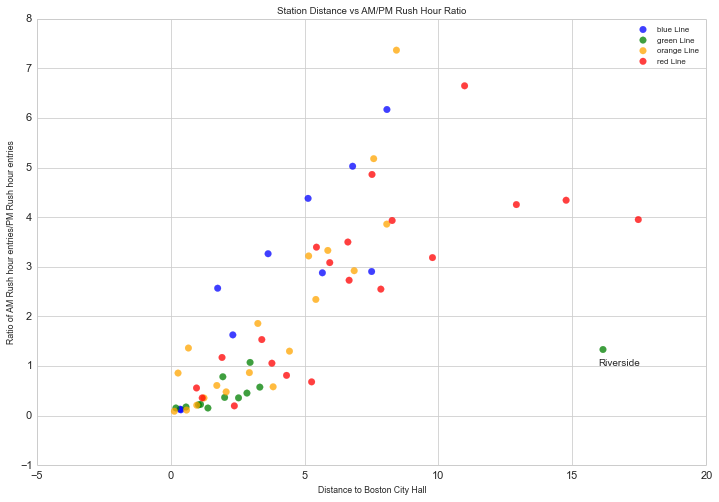

In [210]:
plt.figure(figsize=(12,8))

for i,group in ratio_subset.groupby('line_temp'):
    group_line=group['line_temp'].iloc[0].lower()
    plt.scatter(group['dist_to_center'],group['am_pm_ratio'], s=45,alpha=0.75,color=group_line,label=group_line+' Line')

plt.xlabel('Distance to Boston City Hall')
plt.ylabel('Ratio of AM Rush hour entries/PM Rush hour entries')
plt.legend()
plt.title('Station Distance vs AM/PM Rush Hour Ratio')
plt.annotate('Riverside',xy=(16,1))

plt.show()

### Color by our grouping

As seen below, we can color the stations by the grouping derived earlier and the picture is much prettier. Note that Riverside is an outlier among Group 2 stations because it is the only above-ground rail line that we have gate fare data for.


The fact that the ratio of AM/PM rush hour entries is so cleanly separated by our grouping lends some insight as to why two principal components were sufficient to account for 90% of the variation in the data set. It seems that stations can be almost completely characterized by their rush hour traffic with most of the mid-day activity having little part in differentiating stations.

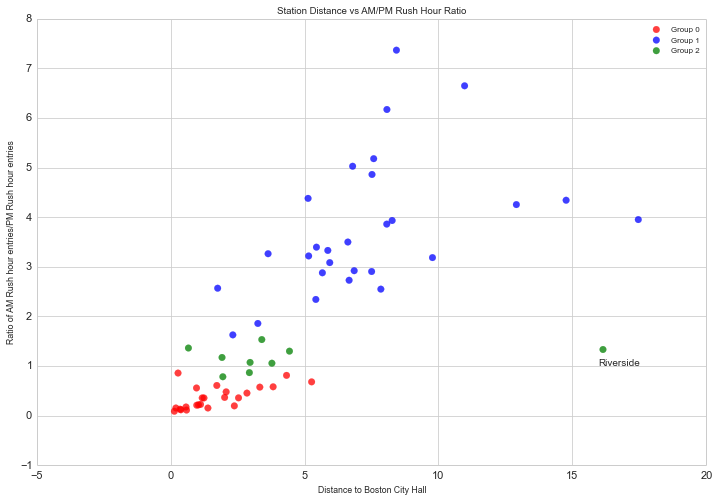

In [208]:
plt.figure(figsize=(12,8))
color_dict={0:'red',1:'blue',2:'green'}

for i,group in ratio_subset.groupby('grouping'):
    group_num=group['grouping'].iloc[0]
    plt.scatter(group['dist_to_center'],group['am_pm_ratio'], s=45,alpha=0.75,color=color_dict[group_num],label='Group '+str(group_num))

plt.xlabel('Distance to Boston City Hall')
plt.ylabel('Ratio of AM Rush hour entries/PM Rush hour entries')
plt.legend()
plt.title('Station Distance vs AM/PM Rush Hour Ratio')
plt.annotate('Riverside',xy=(16,1))

plt.show()

#Conclusion:

We set out to discover a more natural way of identifying similar stations based upon their ridership patterns as opposed to arbitrary groupings like line color. Our methods relied **solely upon average entries** and did not incorporate any information regarding station location or which stations were connected to one another. This makes it all the more exciting that our groupings reflect similar ridership patterns possibly brought about by a station's proximity to the city and the general area surrounding the station.
